In [1]:
import os
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [2]:
# Set your data directory
data_dir = "data/image/sign-language"  # Your directory where files like family-00.jpg are located

# Define the classes found by scanning the folder. They should match the words you have:
categories = ["family", "hello", "help", "house", "loveyou", "no", "please", "sorry", "thankyou", "yes"]

In [3]:
# Create a mapping from class name to index
class_to_idx = {c: i for i, c in enumerate(categories)}

class SignLanguageDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.fnames = sorted([f for f in os.listdir(data_dir) if f.lower().endswith('.jpg')])
        
        # Filter only files that have a known category
        self.fnames = [f for f in self.fnames if f.split("-")[0] in class_to_idx]
        
    def __len__(self):
        return len(self.fnames)
    
    def __getitem__(self, idx):
        fname = self.fnames[idx]
        label_str = fname.split("-")[0]
        label = class_to_idx[label_str]

        img_path = os.path.join(self.data_dir, fname)
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

In [4]:
# Define transforms: resize, augment, and normalize
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet means
                         std=[0.229, 0.224, 0.225])
])

dataset = SignLanguageDataset(data_dir, transform=data_transforms)

In [9]:
# Split into train and test sets
test_ratio = 0.2
test_size = int(len(dataset) * test_ratio)
train_size = len(dataset) - test_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)

In [10]:
# Load a pretrained model (ResNet18) and modify it
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
num_features = model.fc.in_features
# Replace the fully connected layer and add dropout
model.fc = nn.Sequential(
    nn.Dropout(p=0.5),  # Add dropout with p=0.5
    nn.Linear(num_features, len(categories))
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [11]:
# Define loss function and optimizer with L2 regularization
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)  # L2 regularization with weight_decay=1e-4

In [12]:
# Training loop
epochs = 20
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    running_correct = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * images.size(0)
        running_correct += torch.sum(preds == labels).item()
    
    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_correct / len(train_dataset)
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}")

Epoch 1/20, Train Loss: 2.5495, Train Acc: 0.1566
Epoch 2/20, Train Loss: 0.9218, Train Acc: 0.7831
Epoch 3/20, Train Loss: 0.5448, Train Acc: 0.8554
Epoch 4/20, Train Loss: 0.3277, Train Acc: 0.9036
Epoch 5/20, Train Loss: 0.2062, Train Acc: 0.9639
Epoch 6/20, Train Loss: 0.1225, Train Acc: 0.9759
Epoch 7/20, Train Loss: 0.0582, Train Acc: 0.9880
Epoch 8/20, Train Loss: 0.0431, Train Acc: 1.0000
Epoch 9/20, Train Loss: 0.0982, Train Acc: 0.9880
Epoch 10/20, Train Loss: 0.0645, Train Acc: 0.9880
Epoch 11/20, Train Loss: 0.0423, Train Acc: 0.9880
Epoch 12/20, Train Loss: 0.0566, Train Acc: 0.9880
Epoch 13/20, Train Loss: 0.0166, Train Acc: 1.0000
Epoch 14/20, Train Loss: 0.1031, Train Acc: 0.9880
Epoch 15/20, Train Loss: 0.0390, Train Acc: 0.9880
Epoch 16/20, Train Loss: 0.0185, Train Acc: 0.9880
Epoch 17/20, Train Loss: 0.0160, Train Acc: 1.0000
Epoch 18/20, Train Loss: 0.0276, Train Acc: 1.0000
Epoch 19/20, Train Loss: 0.0065, Train Acc: 1.0000
Epoch 20/20, Train Loss: 0.0212, Train A

Test Accuracy: 45.00%


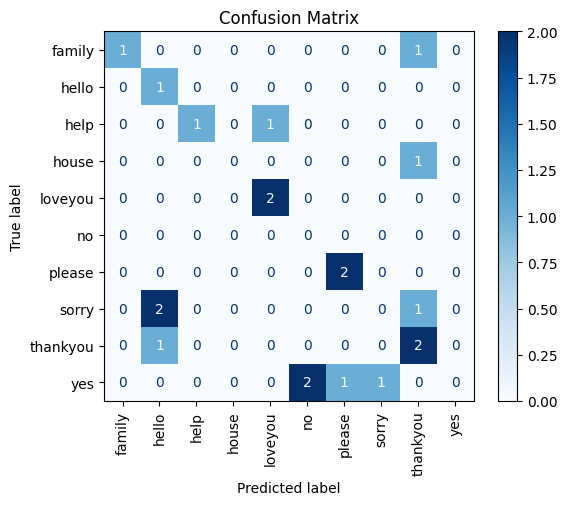

In [13]:
# Evaluation
model.eval()
test_correct = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        test_correct += torch.sum(preds == labels).item()
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_acc = test_correct / len(test_dataset)
print(f"Test Accuracy: {test_acc*100:.2f}%")

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds, labels=list(range(len(categories))))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=categories)
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title("Confusion Matrix")
plt.show()